In [1]:
"""
TODO: 
- do historical and new transactions separately
- check for columns of all nan, inf, or single value and remove them
- also get mode of cat columns and target-encode them
- permutation-based feature importance
"""

'\nTODO: \n- do historical and new transactions separately\n- check for columns of all nan, inf, or single value and remove them\n- also get mode of cat columns and target-encode them\n- permutation-based feature importance\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

# Define what float type to use
float_t = 'float32'

## Load card data

In [3]:
# Load card data
# no nulls in test/train except for ONE ROW in test! (first_active_month)
dtypes = {
  'card_id':            'str',     # 201917 unique vals
  'target':             'float32', # -33.22 thru ~18
  'first_active_month': 'str',     # 2011-10 thru 2018-02
  'feature_1':          'uint8',   # 1 thru 5
  'feature_2':          'uint8',   # 1 thru 3
  'feature_3':          'uint8',   # 0 and 1
}
train = pd.read_csv('../input/train.csv',
                    usecols=dtypes.keys(),
                    dtype=dtypes)
del dtypes['target']
test = pd.read_csv('../input/test.csv',
                   usecols=dtypes.keys(),
                   dtype=dtypes)

# Add target col to test
test['target'] = np.nan

# Merge test and train
cards = pd.concat([train, test])

As a quick sanity check, let's make sure there aren't any `card_id`s which are in both test and train:

In [4]:
print('Num unique in train:  ', test['card_id'].nunique())
print('Num unique in test:   ', train['card_id'].nunique())
print('The sum:              ', test['card_id'].nunique()+train['card_id'].nunique())
print('Num unique in merged: ', cards['card_id'].nunique())

Num unique in train:   123623
Num unique in test:    201917
The sum:               325540
Num unique in merged:  325540


OK good, there aren't.  Now we can delete the original dataframes.

In [5]:
del train, test
gc.collect()

14

Let's take a look at the cards data.

In [6]:
cards.sample(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
97550,2015-04,C_ID_d8490326d3,3,3,1,NaN
195276,2017-06,C_ID_757389449e,3,3,1,0.874132
138155,2017-07,C_ID_ddaf3ab3bf,3,2,1,-1.798101
104955,2017-01,C_ID_9dd62c2d37,3,2,1,5.225634
161150,2017-02,C_ID_dab44091ab,2,1,0,0.584714
190487,2017-06,C_ID_3f62f171b2,3,3,1,1.654085
1245,2017-06,C_ID_e65a7de206,1,1,0,-0.923933
113766,2017-01,C_ID_c22c3bfb28,5,2,1,0.048070
175975,2016-08,C_ID_ef1f31f02e,4,2,0,0.156252
15560,2016-02,C_ID_053fda0fd8,2,2,0,NaN


The `card_id`s always start with `C_ID_`.  That's kind of a waste of space...  All the `card_id`s are the same length:

In [7]:
cards['card_id'].apply(len).unique()

array([15])

If we cut off the prefix, the remaining strings appear to be all hexidecimal (represented by values 0-9 and a-f):

In [8]:
cards['card_id'].str.slice(5, 15).sample(10)

134472    e334621c33
71909     3d2263ce96
59569     1fb571af54
173385    b0d6b0a8db
79570     0ad19c992f
116950    dbbd697213
73096     591c51a260
51220     961b056b20
15835     662f73de38
146268    8a17af8426
Name: card_id, dtype: object

We can check that every single entry is indeed a hexideximal:

In [9]:
(cards['card_id']
 .str.slice(5, 15)
 .apply(lambda x: all(e in '0123456789abcdef' for e in x))
 .all())

True

To save space, we could convert the `card_id`s to integers like this:

In [10]:
#cards['card_id'] = cards['card_id'].apply(lambda x: int(x, 16)).astype('uint64')

There are 5 bytes worth of hex info in the card ids, and the values span the full 5-byte range, so we'd have to use a 64-bit integer to represent them (instead of a 32-bit int, which is only 4 bytes).  BUT, there are only 201,917 unique `card_id`s in `train.csv` and 123,623 in `test.csv`, which can easily be represented by a `uint32` (which stores values up to ~4 billion).  The inneficiency of using a 64-bit representation for something where a 32-bit reprentation would do... Bothers me. \*eye twitches\*

To use a 32-bit integer, we'll create a map between the card_id and a unique integer which identifies it, and then map the string values to integer values.  (we need to create a map so that we can map the values in the transactions data in the exact same way)

In [11]:
# Create a map from card_id to unique int
card_id_map = dict(zip(
    cards['card_id'].values,
    cards['card_id'].astype('category').cat.codes.values
))

# Map the values
cards['card_id'] = cards['card_id'].map(card_id_map).astype('uint32')

Now our `card_id`s are 32-bit integers:

In [12]:
cards.sample(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
43929,2016-03,92956,4,2,0,1.000000
89168,2017-04,44679,2,2,0,2.561261
7581,2017-11,308599,1,1,0,NaN
19591,2017-09,134778,5,2,1,-0.360641
189930,2015-12,221394,5,1,1,-0.575749
79676,2017-02,230200,3,2,1,-2.198756
105775,2017-02,233318,5,1,1,0.000000
90276,2016-10,111892,1,1,0,NaN
59203,2016-02,11612,5,1,1,-1.291789
26241,2015-05,36304,4,2,0,3.426385


Next, we'll convert the `first_active_month` from a string to a datetime.  Unfortunately, there is one.  Single.  Row.  Where `first_active_month` is NaN.

In [13]:
cards[cards['first_active_month'].isnull()]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
11578,NaN,247334,5,2,1,NaN


But other than that row, all the other `first_active_months` are in `YYYY-MM` format:

In [14]:
def nanlen(x):
    if type(x) is float:
        return 'NaN'
    else:
        return len(x)
    
cards['first_active_month'].apply(nanlen).unique()

array([7, 'NaN'], dtype=object)

So, we can convert `first_active_month` column to datetime format.

In [15]:
# Convert first_active_month to datetime
cards['first_active_month'] = pd.to_datetime(cards['first_active_month'],
                                             format='%Y-%m')

Finally, we'll set the index to be the `card_id`.

In [16]:
# Make card_id the index
cards.set_index('card_id', inplace=True)
gc.collect()
cards.sample(10)

,first_active_month,feature_1,feature_2,feature_3,target
card_id,,,,,
16226,2016-12-01,2,1,0,NaN
168609,2016-07-01,4,2,0,NaN
139126,2017-01-01,5,2,1,-0.592614
309033,2016-12-01,4,2,0,NaN
17598,2017-03-01,3,2,1,-1.880612
110596,2017-09-01,3,3,1,NaN
182968,2017-10-01,3,1,1,2.466773
207970,2017-05-01,1,1,0,0.860249
260668,2016-09-01,1,3,0,-0.169266


## Load Merchants Data

NOTE: some cols are in both merchants dataset and the transactions datasets, and the values differ.  Probably those are values which are properties of the merchants but have changed between the time the purchase was made and the time at which the merchants table was compiled.  So, for per-transaction information we'll use the version of the information in the transactions dataset, not the info from the merchants dataset.

In [17]:
# Datatypes of each column
# (don't load cols which are in transactions data, just use those vals)
# Nulls: NO nulls except for 13 rows in avg_sales_lag{3,6,12}
dtypes = {
  'merchant_id':                 'str',     # 334633 unique values
  'merchant_group_id':           'uint32',  # 1 thru 112586 (w/ some missing, ~109k uniques)
  'numerical_1':                 'float32', # ~ -0.06 thru ~ 183.8 (only 951 unique vals?)
  'numerical_2':                 'float32', # roughly the same as above
  'most_recent_sales_range':     'str',     # A, B, C, D, or E
  'most_recent_purchases_range': 'str',     # A, B, C, D, or E
  'avg_sales_lag3':              'float32', # most between 0 and 2, if you transform by 1/x, all but 3 are between 0 and 4
  'avg_purchases_lag3':          'float32', # most between 0 and 2, if you transform by 1/x, all but 3 are between 0 and 4
  'active_months_lag3':          'uint8',   # 1 to 3 
  'avg_sales_lag6':              'float32', # similar to avg_sales_lag3
  'avg_purchases_lag6':          'float32', # similar to avg_purchases_lag3
  'active_months_lag6':          'uint8',   # 1 to 6
  'avg_sales_lag12':             'float32', # similar to avg_sales_lag3
  'avg_purchases_lag12':         'float32', # similar to avg_purchases_lag3
  'active_months_lag12':         'uint8',   # 1 to 12
  'category_4':                  'str',     # Y or N
}

# Load the data
merchants = pd.read_csv('../input/merchants.csv',
                        usecols=dtypes.keys(),
                        dtype=dtypes)

In [18]:
# Map merchant_id to integer
merch_id_map = dict(zip(
    merchants['merchant_id'].values,
    merchants['merchant_id'].astype('category').cat.codes.values
))

In [19]:
def preprocess_merch_data(df):
    
    # Convert merchant ID to numbers
    df['merchant_id'] = df['merchant_id'].map(merch_id_map).astype('float32')

    # Inverse transforms
    inversions = [
        'avg_sales_lag3',
        'avg_sales_lag6',
        'avg_sales_lag12',
        'avg_purchases_lag3',
        'avg_purchases_lag6',
        'avg_purchases_lag12',
    ]
    for col in inversions:
        df[col] = 1.0/df[col]

    # Encode categorical columns
    bool_map = {'Y': 1, 'N': 0}
    five_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    conversions = [
        ('category_4', bool_map, 'uint8'),
        ('most_recent_sales_range', five_map, 'uint8'),
        ('most_recent_purchases_range', five_map, 'uint8')
    ]
    for col, mapper, new_type in conversions:
        df[col] = df[col].map(mapper).astype(new_type)
        
    # Clean up
    gc.collect()

# Preprocess the merchants data
preprocess_merch_data(merchants)

## Load Transactions Data

In [20]:
# Datatypes of each column
# only NaNs are in category_3, merchant_id, and category_2
dtypes = {
    'authorized_flag':      'str',     # Y or N
    'card_id':              'str',     # 325540 unique values
    'city_id':              'int16',   # -1 then 1 to 347 (is -1 supposed to be nan?)
    'category_1':           'str',     # Y or N
    'installments':         'int8',    # -25, then -1 thru 12 (-1 supposed to be nan?)
    'category_3':           'str',     # A, B, C, and nan (ordinal?)
    'merchant_category_id': 'int16',   # 2 to 891
    'merchant_id':          'str',     # 334633 unique values and nans (164697 nans!)
    'month_lag':            'int8',    # -13 thru 0
    'purchase_amount':      'float32', # min: -0.746, med: -0.699, max: 11269.667
    'purchase_date':        'str',     # YYYY-MM-DD hh:mm:ss
    'category_2':           'float32', # 1 thru 5 and nan (ordinal?)
    'state_id':             'int8',    # -1 then 1 thru 24
    'subsector_id':         'int8'     # 1 thru 41
}

# Load the data
hist_trans = pd.read_csv('../input/historical_transactions.csv', 
                         usecols=dtypes.keys(),
                         dtype=dtypes)
new_trans = pd.read_csv('../input/new_merchant_transactions.csv', 
                        usecols=dtypes.keys(),
                        dtype=dtypes)

# Merge new_merchant_transactions and historical_transactions
#trans = pd.concat([hist_trans, new_trans])

# Clean up
#del hist_trans, new_trans
#gc.collect()

We also need to convert the `card_id` to an integer as before, `merchant_id` to an integer in the same way, convert the `purchase_date` column (which has been loaded as a string) to datetime format, and encode the categorical columns.

In [21]:
def preprocess_trans_data(df):
    
    # Convert card_id and merchant_id to numbers
    df['card_id'] = df['card_id'].map(card_id_map).astype('uint32')
    df['merchant_id'] = df['merchant_id'].map(merch_id_map).astype('float32')

    # Convert purchase_date to datetime
    df['purchase_date'] = df['purchase_date'].str.slice(0, 19)
    df['purchase_date'] = pd.to_datetime(df['purchase_date'],
                                         format='%Y-%m-%d %H:%M:%S')

    # Encode categorical columns
    bool_map = {'Y': 1, 'N': 0}
    three_map = {'A': 0, 'B': 1, 'C': 2}
    conversions = [
        ('authorized_flag', bool_map, 'uint8'),
        ('category_1', bool_map, 'uint8'),
        ('category_3', three_map, 'float32'), #has NaNs so have to use float
    ]
    for col, mapper, new_type in conversions:
        df[col] = df[col].map(mapper).astype(new_type)
        
    # Clean up
    gc.collect()

# Preprocess the transactions data
preprocess_trans_data(hist_trans)
preprocess_trans_data(new_trans)

## Merge merchants with transactions data

In [22]:
# Merge transactions with merchants data
hist_trans = pd.merge(hist_trans, merchants, on='merchant_id')
new_trans = pd.merge(new_trans, merchants, on='merchant_id')
del merchants
gc.collect()

hist_trans.sample(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4
23645691,1,173904,331,0,0,0.0,705,8640.0,-2,-0.687628,2017-12-23 20:16:57,NaN,-1,33,555,0.130913,0.101168,1,1,0.961538,0.955294,3,0.943396,0.952670,6,0.943396,0.969221,12,0
10927265,1,244594,158,0,0,0.0,705,209856.0,-7,0.154683,2017-06-02 10:11:36,1.0,15,33,1145,0.418445,-0.047556,0,0,1.010101,0.999937,3,1.000000,0.985058,6,1.000000,0.987846,12,1
3551309,1,311636,69,0,0,0.0,367,82480.0,-4,-0.722640,2017-10-09 16:31:08,1.0,9,16,620,2.441085,-0.057471,0,0,0.990099,0.982323,3,1.020408,1.009282,6,1.041667,1.018937,12,1
29118624,1,310954,342,0,1,1.0,373,200069.0,-12,-0.551924,2017-02-20 11:31:12,5.0,20,18,41217,-0.057471,-0.057471,3,4,1.149425,0.902174,3,1.030928,0.848382,6,1.020408,0.819753,12,0
23325326,1,128291,209,0,0,0.0,705,166222.0,-3,-0.696945,2017-11-21 18:19:48,1.0,9,33,21724,-0.047556,-0.057471,2,1,0.970874,0.983101,3,0.943396,0.963504,6,0.900901,0.939682,12,0
4449978,1,239048,17,0,1,1.0,278,94223.0,-5,-0.599423,2017-04-19 21:33:25,4.0,22,37,35,27.575367,27.317581,0,0,0.892857,0.887668,3,0.877193,0.874499,6,0.840336,0.840987,12,1
1193391,1,252988,69,0,0,0.0,879,854.0,-1,-0.731881,2017-12-28 22:52:14,1.0,9,29,35,-0.047556,-0.057471,4,4,0.144300,0.078708,3,0.118765,0.063069,6,0.116686,0.061653,7,1
27913851,1,236316,344,0,0,0.0,705,93713.0,-1,-0.695442,2018-01-15 18:05:59,2.0,18,33,7966,-0.057471,-0.057471,3,3,0.649351,0.801136,3,0.775194,0.816208,6,0.806452,0.813071,12,0
10195144,1,248019,69,0,0,0.0,506,270916.0,-9,-0.259418,2017-05-22 12:10:40,1.0,9,30,16072,-0.047556,-0.047556,1,1,0.800000,0.856248,3,0.534759,0.453232,6,0.364964,0.284162,12,1
12944827,1,151668,158,0,0,0.0,462,130313.0,-6,-0.733159,2017-08-24 10:01:54,1.0,15,31,35,36.597931,33.345840,1,1,0.925926,0.937943,3,0.900901,0.921212,6,0.884956,0.922029,12,1


## Feature Engineering (for Transactions)

First, let's create some features involving when the transactions occurred.

In [23]:
# Compute features from purchase time/date
for df in [hist_trans, new_trans]:
    tpd = df['purchase_date']
    ref_date = np.datetime64('2017-09-01')
    one_hour = np.timedelta64(1, 'h')
    df['purchase_hour'] = tpd.dt.hour.astype('uint8')
    df['purchase_day'] = tpd.dt.dayofweek.astype('uint8')
    df['purchase_week'] = tpd.dt.weekofyear.astype('uint8')
    df['purchase_month'] = tpd.dt.month.astype('uint8')
    df['purchase_weekend'] = (df['purchase_day'] >=5 ).astype('uint8')
    df['purchase_time'] = ((tpd - ref_date) / one_hour).astype('float32')
    df['ref_date'] = ((tpd - pd.to_timedelta(df['month_lag'], 'M')
                          - ref_date ) / one_hour).astype('float32')

    # Time sime first active
    tsfa = pd.merge(df[['card_id']], 
                    cards[['first_active_month']].copy().reset_index(),
                    on='card_id', how='left')
    df['time_since_first_active'] = ((tsfa['first_active_month'] - tpd)
                                     / one_hour).astype('float32')

    # TODO: whether the day is a holiday or week before a holiday or something?

    # Clean up
    del tsfa
    del df['purchase_date']
    gc.collect()

Now we can convert `first_active_month` to months.

In [24]:
cards['first_active_month'] = (12*(cards['first_active_month'].dt.year-2011) + 
                               cards['first_active_month'].dt.month).astype('float32')

In [25]:
hist_trans.sample(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,category_2,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,purchase_hour,purchase_day,purchase_week,purchase_month,purchase_weekend,purchase_time,ref_date,time_since_first_active
21342971,1,217238,149,0,0,0.0,34,215974.0,-2,-0.655547,5.0,20,38,35,2.282447,2.103978,1,2,0.952381,0.879713,3,0.943396,0.798430,6,0.934579,0.793354,12,0,8,4,50,12,0,2528.032715,3989.002686,-3272.032715
5004379,1,27602,143,0,0,0.0,309,116626.0,-1,-0.633187,5.0,5,21,17285,0.329211,-0.057471,0,0,1.030928,0.958826,3,1.000000,0.903032,6,0.952381,0.892147,12,1,11,3,26,6,0,-1524.344727,-793.859741,-7979.655273
22253271,1,318033,69,0,1,1.0,560,66345.0,-9,-0.722249,1.0,9,34,41331,-0.057471,-0.057471,3,2,1.030928,1.028785,3,1.075269,1.079686,6,1.086957,1.105388,12,1,13,1,19,5,0,-2746.961426,3827.403564,-205.038605
17213187,1,306229,80,0,1,1.0,705,281789.0,-5,-0.629400,4.0,4,33,291,-0.027726,-0.027726,2,2,1.041667,1.021030,3,1.030928,1.035967,6,0.943396,0.994032,12,0,12,5,37,9,1,372.055847,4024.480713,-8412.055664
3110022,1,242558,-1,1,3,2.0,511,190027.0,-10,-0.673578,NaN,-1,7,35,-0.057471,-0.057471,0,0,1.063830,1.087479,3,1.219512,1.277139,6,1.538462,1.712328,12,1,2,5,11,3,1,-4005.147949,3299.701904,-6242.852051
11120893,1,66245,308,0,0,0.0,705,79683.0,-2,-0.494012,1.0,16,33,9443,0.002019,-0.057471,1,0,0.961538,0.949041,3,0.934579,0.934306,6,1.010101,1.008807,12,0,20,6,25,6,1,-1611.792480,-150.822495,-10820.207031
28519030,1,78657,91,0,1,1.0,108,38062.0,-2,-0.702129,1.0,12,34,37191,-0.057471,-0.057471,4,4,1.176471,1.195312,3,0.980392,1.066202,6,0.980392,0.963780,12,0,9,6,50,12,1,2577.258057,4038.228027,-5529.257812
10685690,1,116966,17,0,0,0.0,367,139176.0,-1,-0.573953,4.0,22,16,18169,0.497764,0.011934,1,0,0.980392,0.956968,3,1.020408,0.985108,6,1.052632,1.011582,12,1,11,2,5,1,0,3659.632812,4390.117676,-37259.632812
13869560,1,249516,159,0,0,0.0,367,283677.0,-1,-0.528332,1.0,9,16,620,-0.007896,-0.057471,1,1,0.943396,0.928168,3,0.900901,0.870041,6,0.900901,0.863465,12,0,14,1,41,10,0,950.476685,1680.961670,-3158.476562
3194527,0,314943,-1,1,10,2.0,879,190027.0,-2,-0.463373,NaN,-1,29,35,-0.057471,-0.057471,0,0,1.063830,1.087479,3,1.219512,1.277139,6,1.538462,1.712328,12,1,0,0,46,11,0,1752.528931,3213.498779,-7584.528809


## Feature Engineering (aggregations from transactions -> cards)

Now we engineer features for each card ID by applying aggregation functions to each card's transactions data.  First we need to group the transactions by `card_id`.

In [26]:
# Group transactions by card id
hist_trans = hist_trans.groupby('card_id', sort=False)
new_trans = new_trans.groupby('card_id', sort=False)

Can we just compute the aggregations and store it in memory?  Shouldn't be that much in theory.  If we store each col as float32s (or similar space for ints), then we should only be using:

In [27]:
# 4 binary aggs (3 new cols each)
# 14 categorical aggs (2 new cols each)
# 18 continuous aggs (7 new cols each)
print(cards.shape[0] * 4*(6 + 4*3 + 14*2 + 18*7), ' Bytes')

223971520  Bytes


224 MB?  Psssh we got this.

First let's define some custom aggregation functions:

In [28]:
def entropy(series):
    """Categorical entropy"""
    probs = series.value_counts().values.astype('float32')
    probs = probs / np.sum(probs)
    probs[probs==0] = np.nan
    return -np.nansum(probs * np.log2(probs))

def mean_diff(series):
    """Mean difference between consecutive items in a series"""
    ss = series.sort_values()
    return (ss - ss.shift()).mean()

def mode(series):
    """Most common element in a series"""
    return series.mode()[0]

And then we can perform the aggregations.

In [29]:
#%pdb on

# Aggregations to perform for each predictor type
binary_aggs = ['sum', 'mean', 'nunique']
categorical_aggs = ['nunique', entropy]
continuous_aggs = ['min', 'max', 'sum', 'mean', 'std', 'skew', mean_diff]

# Aggregations to perform on each column
aggs = {
    'authorized_flag':             binary_aggs,
    'city_id':                     categorical_aggs,
    'category_1':                  binary_aggs,
    'installments':                continuous_aggs,
    'category_3':                  categorical_aggs + ['mean'], #might be ordinal
    'merchant_category_id':        categorical_aggs,
    'merchant_id':                 categorical_aggs,
    'month_lag':                   continuous_aggs,
    'purchase_amount':             continuous_aggs,
    'purchase_time':               continuous_aggs + ['count'],
    'purchase_hour':               categorical_aggs + [mode],
    'purchase_day':                categorical_aggs + [mode],
    'purchase_week':               categorical_aggs + continuous_aggs + [mode],
    'purchase_month':              categorical_aggs + continuous_aggs + [mode],
    'purchase_weekend':            binary_aggs,
    'ref_date':                    continuous_aggs,
    'time_since_first_active':     continuous_aggs,
    'category_2':                  categorical_aggs + ['mean'], #also might be ordinal
    'state_id':                    categorical_aggs,
    'subsector_id':                categorical_aggs,
    'merchant_group_id':           categorical_aggs,
    'numerical_1':                 continuous_aggs,
    'numerical_2':                 continuous_aggs,
    'most_recent_sales_range':     categorical_aggs + ['mean'], #ordinal?
    'most_recent_purchases_range': categorical_aggs + ['mean'], #orindal?
    'avg_sales_lag3':              continuous_aggs,
    'avg_purchases_lag3':          continuous_aggs,
    'active_months_lag3':          continuous_aggs,
    'avg_sales_lag6':              continuous_aggs,
    'avg_purchases_lag6':          continuous_aggs,
    'active_months_lag6':          continuous_aggs,
    'avg_sales_lag12':             continuous_aggs,
    'avg_purchases_lag12':         continuous_aggs,
    'active_months_lag12':         continuous_aggs,
    'category_4':                  binary_aggs,
}

# Perform each aggregation
for col, funcs in aggs.items():
    for func in funcs:
        
        # Get name of aggregation function
        if isinstance(func, str):
            func_str = func
        else:
            func_str = func.__name__
            
        # Name for new column
        new_col = col + '_' + func_str
            
        # Compute this aggregation
        cards['hist_'+new_col] = hist_trans[col].agg(func).astype('float32')
        cards['new_'+new_col] = new_trans[col].agg(func).astype('float32')

In [30]:
types = []
print("{:>30}  {}".format('COLUMN', 'DATATYPE'))
for col in cards:
    print("{:>30}  {}".format(col, cards[col].dtype))

                        COLUMN  DATATYPE
            first_active_month  float32
                     feature_1  uint8
                     feature_2  uint8
                     feature_3  uint8
                        target  float32
      hist_authorized_flag_sum  float32
       new_authorized_flag_sum  float32
     hist_authorized_flag_mean  float32
      new_authorized_flag_mean  float32
  hist_authorized_flag_nunique  float32
   new_authorized_flag_nunique  float32
          hist_city_id_nunique  float32
           new_city_id_nunique  float32
          hist_city_id_entropy  float32
           new_city_id_entropy  float32
           hist_category_1_sum  float32
            new_category_1_sum  float32
          hist_category_1_mean  float32
           new_category_1_mean  float32
       hist_category_1_nunique  float32
        new_category_1_nunique  float32
         hist_installments_min  float32
          new_installments_min  float32
         hist_installments_max  float32
     

In [31]:
cards.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 325540 entries, 186538 to 172900
Columns: 369 entries, first_active_month to new_category_4_nunique
dtypes: float32(366), uint8(3)
memory usage: 457.9 MB


In [32]:
# Save to feather file
cards.reset_index(inplace=True)
cards.to_feather('card_features_all.feather')

# Read back in with:
# cards = pd.read_feather('../input/card_features.feather')
# cards.set_index('card_id', inplace=True)
# You can read in the data from another kernel by setting this kernel as a data source:
# https://www.kaggle.com/rtatman/importing-data-from-a-kernel

In [33]:
# Make card_id the index (again... featheeeeerr! *shakes fist*)
cards.set_index('card_id', inplace=True)

# No longer need transactions data
del hist_trans
del new_trans
gc.collect()

2576

In [34]:
# TODO: historical and new_merchants_transactions separately, tho that gives you ~340 feats...

In [35]:
# TODO: get mode of categorical cols and then contrast/mean encode them

In [36]:
# TODO: check for columns of all nan, inf, or single value and remove them

## Computing Mutual info between features and target

Just to get some idea of how well each feature corresponds to the target, we can compute the mutual information between each feature and the target.  Let's make a function to compute the mutual information between two vectors.  We'll use the mutual information of the quantile-transformed aggregation scores (just so outliers don't mess up the mutual information calculation).

In [37]:
def quantile_transform(v, res=101):
    """Quantile-transform a vector to lie between 0 and 1"""
    x = np.linspace(0, 100, res)
    prcs = np.nanpercentile(v, x)
    return np.interp(v, prcs, x/100.0)
    
def mutual_information(xi, yi, res=20):
    """Compute the mutual information between two vectors"""
    ix = ~(np.isnan(xi) | np.isinf(xi) | np.isnan(yi) | np.isinf(yi))
    x = xi[ix]
    y = yi[ix]
    N, xe, ye = np.histogram2d(x, y, res)
    Nx, _ = np.histogram(x, xe)
    Ny, _ = np.histogram(y, ye)
    N = N / len(x) #normalize
    Nx = Nx / len(x)
    Ny = Ny / len(y)
    Ni = np.outer(Nx, Ny)
    Ni[Ni == 0] = np.nan
    N[N == 0] = np.nan
    return np.nansum(N * np.log(N / Ni))
    
def q_mut_info(x, y):
    """Compute the mutual information between two quantile-transformed vectors"""
    return mutual_information(quantile_transform(x),
                              quantile_transform(y))

And just to test that those functions work:

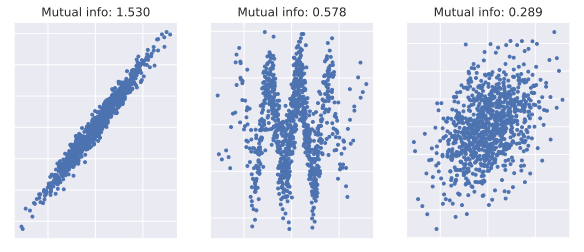

In [38]:
# Show mutual information plots
x = 5*np.random.randn(1000)
y = [x + np.random.randn(1000),
     2*np.sin(x) + np.random.randn(1000),
     x + 10*np.random.randn(1000)]
plt.figure(figsize=(10, 4))
for i in range(3):    
    plt.subplot(1, 3, i+1)
    plt.plot(x, y[i], '.')
    plt.title('Mutual info: %0.3f' % q_mut_info(x, y[i]))
    plt.gca().tick_params(labelbottom=False, labelleft=False)

And now we can actually compute the MI between each column and the target:

In [39]:
# Perform each aggregation and compute MI between the agg and target
mis = []
for col in cards:
    mi = q_mut_info(cards[col], cards['target'])
    mis.append([col, mi])

# Show mutual information between the target and each feature
mi_df = (pd.DataFrame(mis, columns=['Column', 'Mutual_Information'])
            .sort_values('Mutual_Information', ascending=False))
print(mi_df.to_string())

                                       Column  Mutual_Information
4                                      target            2.994813
68                    new_purchase_amount_sum            0.055347
354               new_active_months_lag12_sum            0.053549
242                    new_avg_sales_lag3_sum            0.053544
46                    new_merchant_id_nunique            0.053511
256                new_avg_purchases_lag3_sum            0.053311
92                    new_purchase_time_count            0.053174
6                     new_authorized_flag_sum            0.053174
48                    new_merchant_id_entropy            0.053145
270                new_active_months_lag3_sum            0.053120
312                new_active_months_lag6_sum            0.053060
42           new_merchant_category_id_nunique            0.053004
284                    new_avg_sales_lag6_sum            0.052766
106                 new_purchase_week_nunique            0.052637
298       

## Permutation-based feature importance

Ideally we'd fit a model with each combination of features and use the set of features which gives the best cross-validated results.  But, that'll lead to overfitting to the training data, and also it would take forever.  So, let's just fit the model with all the data, and compute permutation-based feature importances for each feature (based on how worse the model performs when you shuffle the data in one column).

In [40]:
# TODO: catboost?

In [41]:
# TODO: select features based on that
# or maybe even just do pca or something? since now all your features are continuous